In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

In [2]:
depth=np.load('depth.npy')

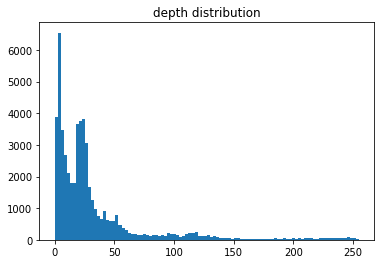

In [3]:
depth_1d = depth.flatten()
depth_1d = np.interp(depth_1d, (depth_1d.min(), depth_1d.max()), (0,255))
plt.hist(depth_1d, bins=100)
plt.gca().set(title='depth distribution')
plt.show()

In [4]:
depth_rescaled = np.reshape(depth_1d, depth.shape)
depth_rescaled = depth_rescaled.astype(np.uint8)

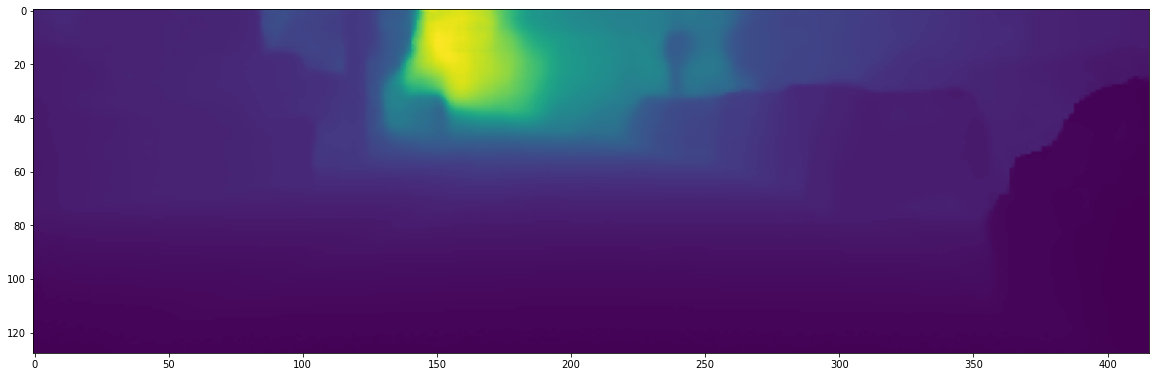

In [5]:
plt.figure(figsize=(20,10))
plt.imshow(np.squeeze(depth_rescaled))

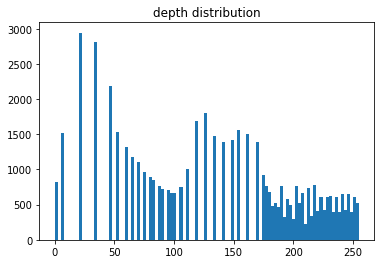

In [6]:
depth_1d = depth_rescaled.flatten()
# depth_norm = None# np.empty_like(depth_1d)
depth_norm=cv.equalizeHist(depth_1d)
plt.hist(depth_norm, bins=100)
plt.gca().set(title='depth distribution')
plt.show()

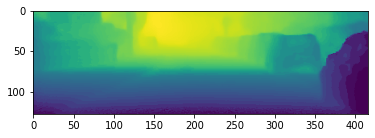

In [7]:
depth_rescaled = np.reshape(depth_norm, depth.shape)
plt.imshow(np.squeeze(depth_rescaled))

In [10]:
cv.imwrite('drive_depth_norm.png', depth_rescaled)

True

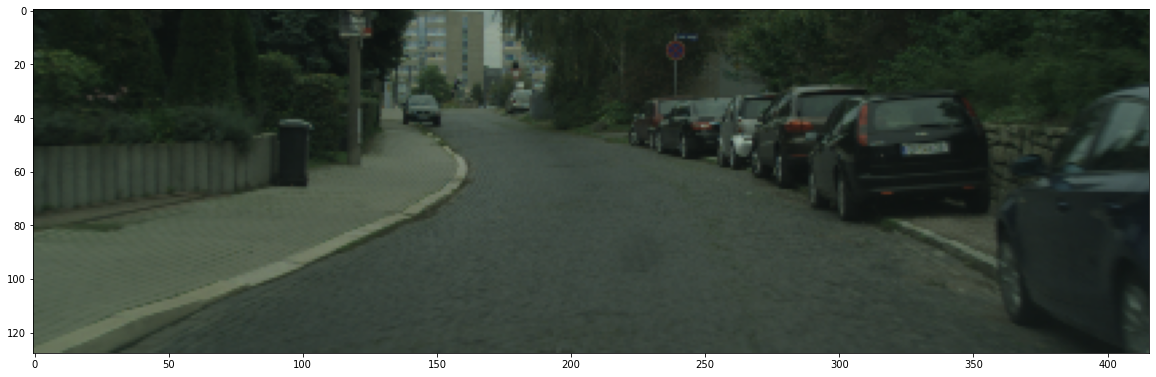

In [43]:
img=cv.cvtColor(cv.imread('drive.png'), cv.COLOR_BGR2RGB)
plt.figure(figsize=(20,10))
plt.imshow(img)

In [1]:
import open3d as o3d
import numpy as np

In [3]:
# load input file
output_path="your_path_to_output_folder/"
pcl_input_file="sample.xyz"
point_cloud= np.loadtxt(pcl_input_file,skiprows=1)

In [4]:
# transform from numpy matrix to o3d object
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud[:,:3])
pcd.colors = o3d.utility.Vector3dVector(point_cloud[:,3:6]/255)
# pcd.normals = o3d.utility.Vector3dVector(point_cloud[:,6:9])

In [4]:
o3d.visualization.draw_geometries([pcd])

In [5]:
distances = pcd.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 3 * avg_dist
bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius, radius * 2]))
dec_mesh = mesh.simplify_quadric_decimation(100000)

RuntimeError: [1;31m[Open3D ERROR] ReconstructBallPivoting requires normals[0;m

In [2]:
color_raw = o3d.io.read_image("drive.png")
depth_raw =  o3d.io.read_image("drive_depth_norm.png")
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw)
print(rgbd_image)

RGBDImage of size 
Color image : 416x128, with 1 channels.
Depth image : 416x128, with 1 channels.
Use numpy.asarray to access buffer data.


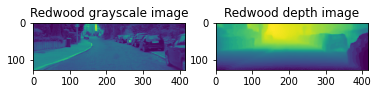

In [14]:
plt.subplot(1, 2, 1)
plt.title('Redwood grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('Redwood depth image')
plt.imshow(rgbd_image.depth)
plt.show()

In [3]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
        rgbd_image,
        o3d.camera.PinholeCameraIntrinsic(
            o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
# Flip it, otherwise the pointcloud will be upside down
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
# o3d.visualization.draw_geometries([pcd])

geometry::PointCloud with 52430 points.

In [ ]:
downpcd = pcd.voxel_down_sample(voxel_size=0.05)
o3d.visualization.draw_geometries([downpcd])

# distances = pcd.compute_nearest_neighbor_distance()
# avg_dist = np.mean(distances)
# radius = 3 * avg_dist
# pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=radius, max_nn=30))
# bpa_mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(pcd,o3d.utility.DoubleVector([radius, radius * 2]))
# # dec_mesh = mesh.simplify_quadric_decimation(100000)

# o3d.visualization.draw_geometries([pcd, rec_mesh])